# CheminTF Self-Contained Notebook

In [1]:
# %load ../src/modules/constants.py
TEMPORAL_ENCODING_DIMENSION=  10
SPATIAL_ENCODING_DIMENSION=  4
TEMPORAL_EMBEDDING_DIMENSION = 64
SPATIAL_EMBEDDING_DIMENSION = 32
EMBEDDING_DIMENSION = SPATIAL_EMBEDDING_DIMENSION + TEMPORAL_EMBEDDING_DIMENSION
OUTPUT_DIMENSION = 3

In [2]:
# %load ../src/modules/features.py
import datetime
import math

import torch
import utm

SCALING_FACTOR_X = 400000.0
DELTA_SCALING_FACTOR_X = 1000.0


def spatial_encoding(
    coordinates: torch.Tensor,
) -> torch.Tensor:

    utm_list = [
        utm.from_latlon(lat.item(), lng.item())[:2]
        for lat, lng in coordinates
    ]

    utm_tensor = torch.tensor(utm_list, dtype=torch.float32)

    deltas = torch.zeros_like(utm_tensor)
    deltas[1:] = utm_tensor[1:] - utm_tensor[:-1]

    deltas /= DELTA_SCALING_FACTOR_X
    normalized = utm_tensor / SCALING_FACTOR_X

    return torch.cat([normalized, deltas], dim=1)

def cyclic_encoding(value: torch.Tensor, period: float) -> torch.Tensor:
    """
    Encode a cyclic temporal feature using sine and cosine transformations.

    :param value: Tensor of feature values (e.g., hour of day).
    :param period: The period of the cycle (e.g., 24 for hours in a day).
    :return: Tensor of shape (N, 2) with sine and cosine encodings.
    """

    angle = 2 * math.pi * value / period
    return torch.stack((torch.sin(angle), torch.cos(angle)), dim=-1)


def temporal_encoding(timestamps: torch.Tensor) -> torch.Tensor:
    """
    Encode timestamps into cyclic temporal features.

    Each timestamp is converted into ten features:
    - Day of week (sin, cos)
    - Hour of day (sin, cos)
    - Minute of hour (sin, cos)
    - Second of minute (sin, cos)
    - Seconds since start
    - Delta seconds from previous timestamp

    :param timestamps: Tensor (N,) — may be on CPU or GPU.
    :return: Tensor (N, 10) on same device as input.
    """
    # ensure dtype is float64 for timestamp precision
    assert timestamps.dtype == torch.float64, "timestamps must be of dtype torch.float64"

    if timestamps.numel() == 0:
        return torch.empty((0, 10), dtype=torch.float32, device=timestamps.device)

    device = timestamps.device
    timestamps = timestamps.to("cpu", dtype=torch.float32)  # datetime requires CPU

    # Convert to datetime objects
    dt_list = [
        datetime.datetime.fromtimestamp(t.item(), tz=datetime.timezone.utc)
        for t in timestamps
    ]

    # Extract calendar components
    day = torch.tensor([dt.weekday() for dt in dt_list], dtype=torch.float32)
    hour = torch.tensor([dt.hour for dt in dt_list], dtype=torch.float32)
    minute = torch.tensor([dt.minute for dt in dt_list], dtype=torch.float32)
    second = torch.tensor([dt.second for dt in dt_list], dtype=torch.float32)

    # Cyclic encodings
    day_enc = cyclic_encoding(day, 7)
    hour_enc = cyclic_encoding(hour, 24)
    minute_enc = cyclic_encoding(minute, 60)
    second_enc = cyclic_encoding(second, 60)

    # Timing features (computed in CPU)
    seconds_since_start = timestamps - timestamps[0]
    delta_seconds = torch.zeros_like(timestamps)
    delta_seconds[1:] = timestamps[1:] - timestamps[:-1]

    # Combine all and move back to original device
    features = torch.cat(
        [
            day_enc,
            hour_enc,
            minute_enc,
            second_enc,
            seconds_since_start.unsqueeze(-1),
            delta_seconds.unsqueeze(-1),
        ],
        dim=1,
    ).to(device)

    # Convert to float32 on the target device
    features = features.to(dtype=torch.float32, device=device)

    return features


In [3]:
# %load ../src/modules/position.py
import torch
from torch import nn


class PositionalEmbedding(nn.Module):
    """GPT-2 style learnable positional encoding."""

    def __init__(self, embedding_dim: int, max_seq_len: int):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_seq_len, embedding_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Adds learned positional encodings to the input tensor.
        Expects x of shape [T, B, E] or [B, T, E].
        """
        device = x.device
        seq_len = x.size(0) if x.dim() == 3 else x.size(1)
        positions = torch.arange(seq_len, device=device, dtype=torch.long)
        pos_enc = self.position_embeddings(positions)
        if x.shape[0] == seq_len:
            pos_enc = pos_enc.unsqueeze(1)  # [T, 1, E]
        else:
            pos_enc = pos_enc.unsqueeze(0)  # [1, T, E]
        return x + pos_enc


In [4]:
# %load ../src/modules/embedding.py
import torch
from torch import nn
from src.modules import constants


class SpatioTemporalEmbeddings(nn.Module):
    """
    Projects encoded spatial and temporal features into a combined embedding,
    with built-in normalization to align feature scales.

    Each feature dimension is standardized across the batch and time axes
    before linear projection, ensuring consistent magnitude between
    spatial (lat/lng) and temporal (timestamps or intervals) inputs.
    """

    def __init__(
        self,
        spatial_encoding_dimension: int = constants.SPATIAL_ENCODING_DIMENSION,
        temporal_encoding_dimension: int = constants.TEMPORAL_ENCODING_DIMENSION,
        spatial_embedding_dimension: int = constants.SPATIAL_EMBEDDING_DIMENSION,
        temporal_embedding_dimension: int = constants.TEMPORAL_EMBEDDING_DIMENSION,
        eps: float = 1e-6,
    ):
        super().__init__()
        self.eps = eps
        self.spatial_fc = nn.Linear(
            spatial_encoding_dimension, spatial_embedding_dimension, dtype=torch.float32
        )
        self.temporal_fc = nn.Linear(
            temporal_encoding_dimension,
            temporal_embedding_dimension,
            dtype=torch.float32,
        )

    def _normalize(self, x: torch.Tensor) -> torch.Tensor:
        """Normalize each feature dimension to zero mean and unit variance."""
        mean = x.mean(dim=(0, 1), keepdim=True)
        std = x.std(dim=(0, 1), keepdim=True)
        return (x - mean) / (std + self.eps)

    def forward(
        self, spatial_input: torch.Tensor, temporal_input: torch.Tensor
    ) -> torch.Tensor:
        # spatial_input, temporal_input: [B, T, D]
        spatial_normed = self._normalize(spatial_input)
        temporal_normed = self._normalize(temporal_input)

        spatial_embed = self.spatial_fc(spatial_normed)
        temporal_embed = self.temporal_fc(temporal_normed)

        return torch.cat(
            [spatial_embed, temporal_embed], dim=-1
        )  # [B, T, spatial_emb + temporal_emb]


In [5]:
# %load ../src/modules/output.py
import torch
from torch import nn, Tensor
from src.modules import constants


class OutputModule(nn.Module):
    """
    Output projection module.

    Projects the transformer hidden representations into the final output space.
    """

    def __init__(self, embed_dim: int = constants.EMBEDDING_DIMENSION):
        """
        :param embed_dim: Dimensionality of transformer embeddings before projection.
        """
        super().__init__()
        self.output_proj = nn.Linear(embed_dim, constants.OUTPUT_DIMENSION, dtype=torch.float32)

    def forward(self, x: Tensor) -> Tensor:
        """
        :param x: Input tensor of shape [T, B, E], representing hidden states
                  from the transformer encoder, where
                  T = sequence length,
                  B = batch size,
                  E = embedding dimension.
        :return: Tensor of shape [T, B, OUTPUT_DIMENSION], representing projected outputs.
        """
        return self.output_proj(x)


In [6]:
# %load ../src/modules/model.py
import torch
from torch import nn, Tensor

from src.modules import constants
from src.modules.embedding import SpatioTemporalEmbeddings
from src.modules.output import OutputModule
from src.modules.position import PositionalEmbedding


def causal_mask(seq_len: int) -> Tensor:
    # Generates an upper-triangular matrix filled with -inf above the diagonal
    # Used to mask future tokens in causal (autoregressive) transformers
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    mask = mask.masked_fill(mask == 1, float("-inf"))
    return mask


class CheminTF(nn.Module):
    def __init__(
        self,
        n_heads: int,
        num_layers: int,
        embed_dim: int = constants.EMBEDDING_DIMENSION,
        max_len: int = 50,
        dropout: float = 0.1,
    ):
        super().__init__()

        self.vector_embedding_layer = SpatioTemporalEmbeddings(
            spatial_encoding_dimension=constants.SPATIAL_ENCODING_DIMENSION,
            temporal_encoding_dimension=constants.TEMPORAL_ENCODING_DIMENSION,
            spatial_embedding_dimension=constants.SPATIAL_EMBEDDING_DIMENSION,
            temporal_embedding_dimension=constants.TEMPORAL_EMBEDDING_DIMENSION,
        )

        self.pos_embedding_layer = PositionalEmbedding(
            embedding_dim=constants.EMBEDDING_DIMENSION, max_seq_len=max_len
        )

        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            # activation => we want some non-linearity here but we want to keep negative values
            activation="gelu",
            nhead=n_heads,
            dim_feedforward=4 * embed_dim,
            dropout=dropout,
            batch_first=False,
            dtype=torch.float32,
        )

        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)

        self.output = OutputModule(embed_dim=embed_dim)


    def forward(self, spatial_input: torch.Tensor, temporal_input: torch.Tensor):
        # x: [T, B, D]
        vector_embeddings = self.vector_embedding_layer(spatial_input, temporal_input)
        # x: [T, B, D]
        T, B, D = vector_embeddings.shape
        embeddings = self.pos_embedding_layer(vector_embeddings)  # [T, B, E]
        mask = causal_mask(T).to(embeddings.device)  # [T, T]

        x = self.transformer(embeddings, mask=mask)  # [T, B, E]

        return self.output(x)


In [7]:
# %load ../src/synthetic_trajectory.py
import math
import random
from typing import List, Tuple


class SyntheticTrajectoryGenerator:
    def __init__(
        self,
        start_lat: float = 56.0,
        start_lng: float = 8.0,
        start_timestamp: int = None,
        step_seconds: int = 60,
        num_points: int = 20,
        delta_lat: float = 0.001,
        delta_lng: float = 0.001,
        noise: float = 0.0,
            enable_turns: bool = True,
        jitter_time: bool = False,
        seed: int = None,
    ):
        if seed is not None:
            random.seed(seed)
        self.start_lat = start_lat
        self.start_lng = start_lng
        self.step_seconds = step_seconds
        self.num_points = num_points
        self.delta_lat = delta_lat
        self.delta_lng = delta_lng
        self.noise = noise
        self.jitter_time = jitter_time
        self.enable_turns = enable_turns

        if start_timestamp is None:
            import datetime

            start_timestamp = int(
                datetime.datetime.now(datetime.timezone.utc).timestamp()
            )
        self.start_timestamp = start_timestamp

    def generate(self) -> List[Tuple[float, float, int]]:
        lat, lng = self.start_lat, self.start_lng
        timestamp = self.start_timestamp

        trajectory = []

        num_turns = random.randint(1, 5) if self.enable_turns else 0
        turning_points = sorted(random.sample(range(2, self.num_points - 2), num_turns))

        delta_lat = self.delta_lat
        delta_lng = self.delta_lng

        for i in range(self.num_points):
            # Apply turning point by changing direction randomly
            if i in turning_points:
                angle = random.uniform(-1.5, 1.5)  # radians
                cos_a = math.cos(angle)
                sin_a = math.sin(angle)
                new_delta_lat = cos_a * delta_lat - sin_a * delta_lng
                new_delta_lng = sin_a * delta_lat + cos_a * delta_lng
                delta_lat, delta_lng = new_delta_lat, new_delta_lng

            # Add noise and jitter
            noise_lat = random.uniform(-self.noise, self.noise)
            noise_lng = random.uniform(-self.noise, self.noise)
            time_offset = random.randint(1, self.step_seconds - 1) if self.jitter_time else self.step_seconds

            trajectory.append(
                (lng + noise_lng, lat + noise_lat, timestamp + time_offset)
            )

            lat += delta_lat
            lng += delta_lng
            timestamp += time_offset

        return trajectory



In [8]:
# %load ../src/dataset.py
import random
import time
import torch
from torch import Tensor
from torch.utils.data import Dataset
from src.modules.features import spatial_encoding, temporal_encoding
from src.synthetic_trajectory import SyntheticTrajectoryGenerator


class SyntheticTrajectoryDataset(Dataset):
    """
    Synthetic trajectory dataset for delta prediction.

    Each trajectory is generated using randomized starting coordinates, timestamps,
    and motion parameters. The dataset provides spatial and temporal feature tensors
    as inputs and delta (Δlat, Δlng) targets for supervised learning.

    :param num_trajectories: Number of synthetic trajectories to generate.
    :param center_lat: Reference latitude for the generation area.
    :param center_lng: Reference longitude for the generation area.
    """

    def __init__(self, num_trajectories: int, center_lat: float = 56.0, center_lng: float = 8.0):
        self.trajs: list[tuple[Tensor, Tensor]] = []
        self.labels: list[Tensor] = []
        self.original_trajs: list[list[tuple[float, float, int]]] = []

        for _ in range(num_trajectories):
            seed = random.randint(0, int(1e6))
            random.seed(seed)

            generator = SyntheticTrajectoryGenerator(
                start_lat=random.uniform(55.5, 56.5),
                start_lng=random.uniform(7.5, 8.5),
                start_timestamp=int(time.time()) + random.randint(-1000, 1000),
                step_seconds=60,
                num_points=random.randint(10, 49),
                delta_lat=random.uniform(-0.001, 0.001),
                enable_turns=True,
                delta_lng=random.uniform(-0.001, 0.001),
                noise=random.uniform(0.0, 0.0001),
                jitter_time=True,
                seed=seed,
            )

            traj = generator.generate()
            coords = torch.tensor([[p[0], p[1]] for p in traj], dtype=torch.float32)
            times = torch.tensor([p[2] for p in traj], dtype=torch.float64)
            temporal_tensor = temporal_encoding(times[:-1])
            spatial_deltas = (coords[1:] - coords[:-1]) * 1000
            temporal_deltas = (times[1:] - times[:-1]) / 60
            temporal_deltas = temporal_deltas.to(torch.float32)
            deltas = torch.cat([spatial_deltas, temporal_deltas.unsqueeze(-1)], dim=-1)
            spatial_tensor = spatial_encoding(coords[:-1])
            assert len(spatial_tensor) == len(deltas)

            self.trajs.append((spatial_tensor, temporal_tensor))
            self.labels.append(deltas)
            self.original_trajs.append(traj)

    def __len__(self) -> int:
        """
        :return: Number of trajectories in the dataset.
        """
        return len(self.trajs)

    def __getitem__(self, idx: int) -> tuple[list[list[tuple[float, float, int]]], tuple[Tensor, Tensor], Tensor]:
        """
        :param idx: Index of the trajectory sample to retrieve.
        :return: ((spatial_tensor, temporal_tensor), delta_tensor)
        """
        spatial, temporal = self.trajs[idx]
        deltas = self.labels[idx]
        return self.original_trajs, (spatial, temporal), deltas


/home/gilles/codes/sandbox/CheminTF/.direnv/python-3.10.12/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/3: 100%|██████████| 704/704 [00:53<00:00, 13.05it/s]


Epoch 01 | Train Loss: 0.063407 | Val Loss: 0.033554 | Val RMSE: 0.1831


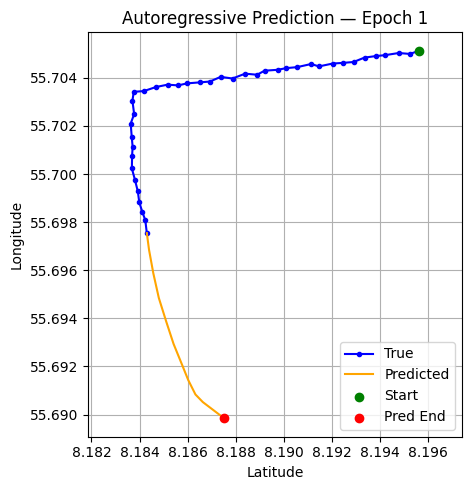

Epoch 2/3: 100%|██████████| 704/704 [00:55<00:00, 12.77it/s]


Epoch 02 | Train Loss: 0.037111 | Val Loss: 0.032899 | Val RMSE: 0.1813


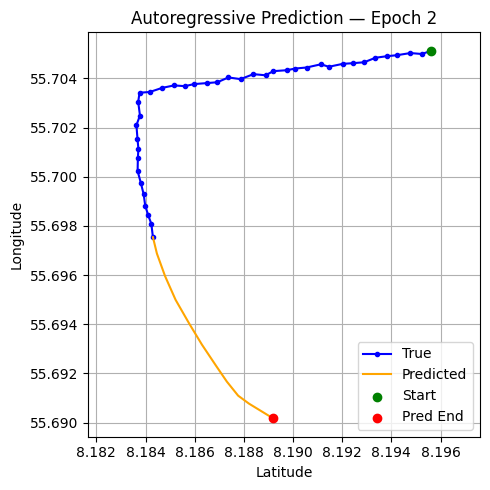

Epoch 3/3: 100%|██████████| 704/704 [00:54<00:00, 13.03it/s]


Epoch 03 | Train Loss: 0.035413 | Val Loss: 0.032705 | Val RMSE: 0.1808


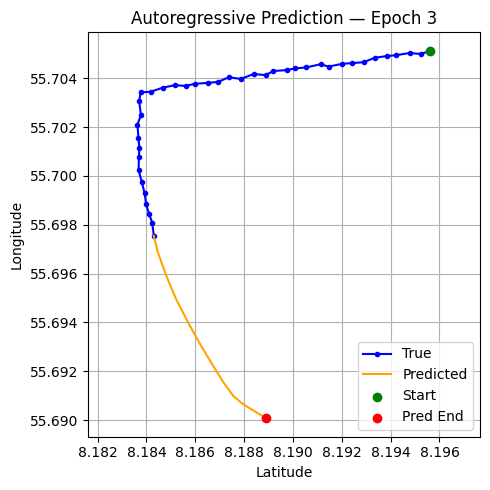

NameError: name 'plt' is not defined

In [10]:
# %load ../src/train.py
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
from src.dataset import SyntheticTrajectoryDataset
from src.modules.model import CheminTF
from src.predict import predict_autoregressive
from src.plot import plot_trajectories


# ============================================================
# Collate function
# ============================================================

def collate_batch(batch: list[tuple[list, tuple[Tensor, Tensor], Tensor]]) -> tuple[list, Tensor, Tensor, Tensor]:
    """Pad variable-length trajectories and stack into [T, B, D] batches."""
    original, spatial_seqs, temporal_seqs, delta_seqs = zip(*[(t, s, t, d) for (t, (s, t), d) in batch])
    max_len = max(seq.shape[0] for seq in spatial_seqs)

    def pad_sequence(seq_list: list[Tensor]) -> Tensor:
        padded = [
            torch.cat([seq, torch.zeros(max_len - seq.shape[0], seq.shape[1])], dim=0)
            for seq in seq_list
        ]
        return torch.stack(padded, dim=1)  # [T, B, D]

    spatial_batch = pad_sequence(spatial_seqs)
    temporal_batch = pad_sequence(temporal_seqs)
    delta_batch = pad_sequence(delta_seqs)
    return original, spatial_batch, temporal_batch, delta_batch



# ============================================================
# Training function
# ============================================================
def train_model(
    num_epochs: int = 20,
    batch_size: int = 8,
    learning_rate: float = 1e-4,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
) -> CheminTF:
    """
    Train CheminTF to predict spatial deltas (Δlat, Δlng, Δt) from spatio-temporal features.
    Adds a validation set and uses a validation trajectory for plotting.
    """
    # ---------------------- Dataset split ----------------------
    full_dataset = SyntheticTrajectoryDataset(num_trajectories=100000)
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    # ---------------------- Model setup ----------------------
    model = CheminTF(n_heads=4, num_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # ---------------------- Metric storage ----------------------
    train_losses, val_losses, val_rmses = [], [], []

    *_, deltas_ref = val_dataset[0]


    # ---------------------- Training loop ----------------------
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for _, spatial, temporal, deltas in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            spatial, temporal, deltas = spatial.to(device), temporal.to(device), deltas.to(device)
            optimizer.zero_grad()
            preds = model(spatial, temporal)
            loss = criterion(preds, deltas)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ---------------------- Validation loop ----------------------
        model.eval()
        val_loss, val_rmse = 0.0, 0.0
        with torch.no_grad():
            for _, spatial, temporal, deltas in val_loader:
                spatial, temporal, deltas = spatial.to(device), temporal.to(device), deltas.to(device)
                preds = model(spatial, temporal)
                loss = criterion(preds, deltas)
                val_loss += loss.item()
                val_rmse += torch.sqrt(torch.mean((preds - deltas) ** 2)).item()
        avg_val_loss = val_loss / len(val_loader)
        avg_val_rmse = val_rmse / len(val_loader)
        val_losses.append(avg_val_loss)
        val_rmses.append(avg_val_rmse)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | Val RMSE: {avg_val_rmse:.4f}")

        # 🔁 Visualize one autoregressive prediction each epoch using VALIDATION reference
        with torch.no_grad():
            coord = val_dataset[0][0][0]  # original trajectory
            spatial_ref = Tensor(Tensor(coord)[:, :2])
            # temporal ref must be float64
            temporal_ref = Tensor(Tensor(coord)[:, 2]).to(torch.float64)

            pred_coords, pred_times = predict_autoregressive(
                model,
                init_coords=spatial_ref,
                init_times=temporal_ref,
                num_future_steps=10,
                device=device,
            )
            plot_trajectories(spatial_ref, pred_coords, epoch)

    # ---------------------- Plot training & validation curves ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", linewidth=2)
    plt.plot(val_losses, label="Val Loss", linewidth=2)
    plt.plot(val_rmses, label="Val RMSE", linewidth=2)
    plt.title("Training & Validation Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model



if __name__ == "__main__":
    trained_model = train_model(num_epochs=3, batch_size=128, device="cuda")
    torch.save(trained_model.state_dict(), "../weights/chemin_tf_deltas.pt")


In [11]:
# evaluate.py
import torch
from torch.utils.data import DataLoader


def evaluate_and_plot(
    weights_path: str = "chemin_tf_deltas.pt",
    num_samples: int = 10,
    num_trajectories: int = 1000,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    """
    Load pretrained CheminTF model and plot autoregressive trajectory predictions.

    Args:
        weights_path: Path to model checkpoint (.pt file)
        num_samples: Number of trajectories to predict and plot
        num_trajectories: Number of synthetic trajectories in dataset
        device: "cuda" or "cpu"
    """
    # ============================================================
    # Load model and weights
    # ============================================================
    model = CheminTF(n_heads=4, num_layers=2).to(device)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

    # ============================================================
    # Prepare validation data
    # ============================================================
    dataset = SyntheticTrajectoryDataset(num_trajectories=num_trajectories)
    val_loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)
    val_iter = iter(val_loader)

    # ============================================================
    # Predict and plot samples
    # ============================================================
    for i in range(num_samples):
        original, spatial, temporal, delta = next(val_iter)
        spatial_ref = spatial.squeeze(1).to(device)
        temporal_ref = temporal.squeeze(1).to(device)
        coords_ref = spatial_ref[:, :2]
        times_ref = temporal_ref[:, 0] if temporal_ref.ndim > 1 else temporal_ref
        times_ref = times_ref.to(torch.float64)
        pred_coords, pred_times = predict_autoregressive(
            model,
            init_coords=coords_ref,
            init_times=times_ref,
            num_future_steps=5,
            device=device,
        )

        plot_trajectories(coords_ref, pred_coords, i)
        print(f"Trajectory {i+1}/{num_samples} plotted ✅")

    print("✅ Evaluation and plotting complete.")


# ============================================================
# Example usage
# ============================================================
if __name__ == "__main__":
    evaluate_and_plot("../weights/chemin_tf_deltas.pt", num_samples=10)


RuntimeError: Error(s) in loading state_dict for CheminTF:
	Missing key(s) in state_dict: "vector_embedding_layer.spatial_fc.weight", "vector_embedding_layer.spatial_fc.bias", "vector_embedding_layer.temporal_fc.weight", "vector_embedding_layer.temporal_fc.bias", "pos_embedding_layer.position_embeddings.weight". 
	Unexpected key(s) in state_dict: "input_encoder.spatial_fc.weight", "input_encoder.spatial_fc.bias", "input_encoder.temporal_fc.weight", "input_encoder.temporal_fc.bias", "pos_encoder.position_embeddings.weight". 